# Gaussian Processes for Regression

In this tutorial we're going to discuss Gaussian Processes.

No tutorial on Gaussian Processes would be complete without starting with the somewhat opaque sentence:

> A Gaussian Process is a distribution over functions.

## Background 
I'm going to go through some background material, feel free to skip sections if you already feel comfortable with them.

It's also worth noting that for illustrations sake, there is a lot of plotting code in this notebook. I have commented where the plotting code is, also feel free to skip over it since it's not important for the actual subject.


### Regression vs Classification

Broadly speaking, most tasks in data science are either classification, or regression. In this tutorial I'm only going to discuss regression (though GPs are capable of doing classification, they are most naturally suited to regression).

### The Gaussian Distribution 

- Introduce the Gaussian distribution
- some notation (mean, variance) 
- basketballers example 
- multivariate Gaussians
- covariance 

The Gaussian distribution (also commonly referred to as the Normal distribution) is one of the most heavily used distributions in data science and machine learning. This is in large part because they appear so often in the world (TODO: reference central limit theorem, law of large numbers), but also because they offer a great deal of mathematical convenience.

A _univariate_ Gaussian distribution is specified by a mean ($\mu$) and a variance ($\sigma^2$). This is often shorted to: $ \mathcal{N}(\mu, \sigma^2) $. 

The equation for the Gaussian pdf is:

$$ p(y|\mu,\sigma^2) = \frac{1}{\sigma \sqrt{2\pi}} \exp \bigg\{ -\frac{1}{2\sigma^2}(y-\mu)^2\bigg\} $$


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import multivariate_normal
plt.style.use('seaborn-whitegrid')

np.random.seed(42)

font = {'size'   : 15}

matplotlib.rc('font', **font)

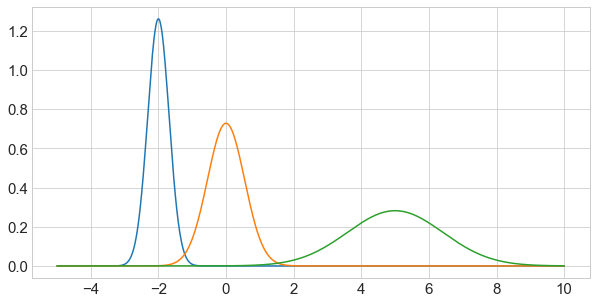

In [3]:
def gaussian(x, mu,sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

mu1, sigma1 = -2, np.sqrt(0.1)
mu2, sigma2 = 0, np.sqrt(0.3)
mu3, sigma3 = 5, np.sqrt(2)

## plotting code
fig, ax = plt.subplots(figsize=(10,5))
x = np.linspace(-5,10,1000)

ax.plot(x, ([gaussian(x_, mu1, sigma1) for x_ in x]))
ax.plot(x, ([gaussian(x_, mu2, sigma2) for x_ in x]))
ax.plot(x, ([gaussian(x_, mu3, sigma3) for x_ in x]))

plt.show()

Imagine we are modelling the height (in centimetres) of a population. We could specify that the mean height of the population was 160cm, with a variance of 10cm ($H_{cm} \sim \mathcal{N}(160, 10^2)$).

We can plot a _probability density_ for this using the Gaussian equation. The _density_ at a given height (in cm) tells us how often we can expect to see people at that height. 

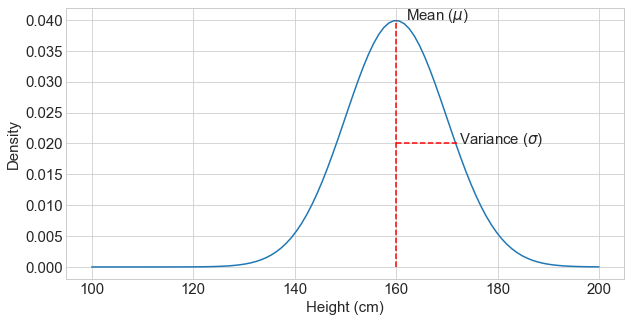

In [4]:
mu, sigma = 160, 10
population_size = 100

# on the x axis, we want all of the heights between 100cm and 200cm
heights = np.linspace(100,200,population_size) # 100 samples
density = [gaussian(x, mu, sigma) for x in heights]



#### plotting code: you can ignore this since it's just annotating
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(heights, density)

ax.plot([160]*10,np.linspace(0,.04,10), linestyle='--', color='red')
ax.plot(np.linspace(160,172,10), [0.02]*10, linestyle='--', color='red')

ax.annotate("Mean ($\mu$)",(162, .04))
ax.annotate("Variance ($\sigma$)", (172.5,0.02))

ax.set_xlabel('Height (cm)')
ax.set_ylabel('Density')
plt.show()

#### Sampling from a Gaussian

One of the benefits of defining our population this way is that we can take samples. We could take 100 samples from our Gaussian (each sample representing the height of one person), and we would expect this list of 100 heights to be roughly representative of our real population.
 
`numpy` provides a particularly simple way to sample from Gaussians. E.g. to take `n` samples:

```
n_samples = np.random.normal(mu, sigma, n) 
```
 
To picture what this looks like, imagine that each of the crosses on the below plot are individual samples from our model:

Samples: 
 [164.96714153 158.61735699 166.47688538 175.23029856 157.65846625
 157.65863043 175.79212816 167.67434729 155.30525614 165.42560044
 155.36582307 155.34270246 162.41962272 140.86719755 142.75082167
 154.37712471 149.8716888  163.14247333 150.91975924 145.87696299]


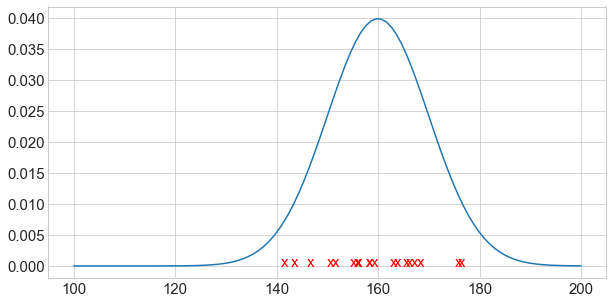

In [5]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(heights, density)

## let's sample
n = 20
samples = np.random.normal(mu, sigma, n)

print('Samples: \n', samples)

for s in samples:
    ax.annotate('x',(s,0), color='red')

plt.show()

Imagine now that we would also like to incorporate _weight_ (in kg) into our model. 

We could define a new Gaussian distribution, with a different mean and variance. If we wanted to sample a new person (represented by a pair of a height and a weight $(h,w)$, we could first draw a sample from our model of height, and then another from our model of weight.


Example of a sampled person: 
    height (cm):  [174.65648769]
    weight (kg):  [48.8711185]


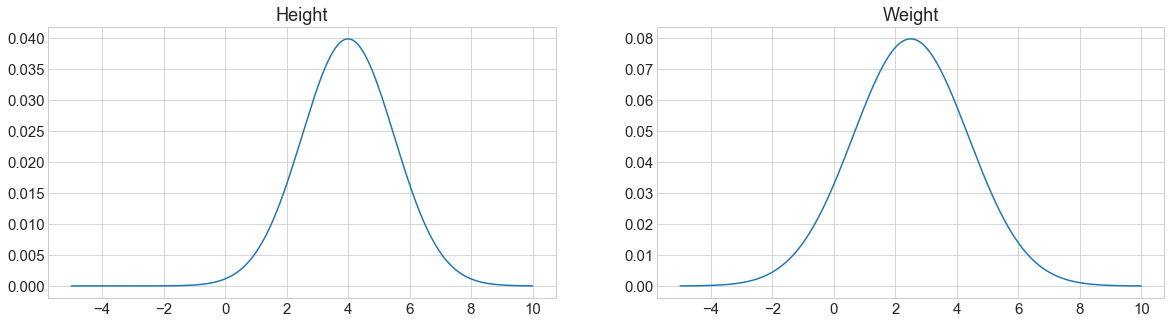

In [6]:
fig, axs = plt.subplots(1,2,figsize=(20,5))
axs = axs.ravel()

mu_h, sigma_h = 160, 10
mu_w, sigma_w = 50, 5

x_h = np.linspace(100,200,1000)
x_w = np.linspace(30,70,1000)

axs[0].plot(x, ([gaussian(x_, mu_h, sigma_h) for x_ in x_h]))
axs[1].plot(x, ([gaussian(x_, mu_w, sigma_w) for x_ in x_w]))


axs[0].set_title('Height')
axs[1].set_title('Weight')


###### TAKING A SAMPLE 
h = np.random.normal(mu_h, sigma_h, 1)
w = np.random.normal(mu_w, sigma_w, 1)

print('Example of a sampled person: ')
print('    height (cm): ', h)
print('    weight (kg): ', w)

plt.show()

## Multivariate Gaussians

The problem with this is that we are assuming that height and weight are independent, when in reality they are heavily linked. We could very easily sample a height from above the mean and a weight from below the mean, and we would have nothing to alert us that this was unlikely.

So far, we have been considering _univariate_ Gaussians, and treating each variable as independent. When we have multiple, related variables (e.g. height and weight), a more powerful choice is the _multivariate_ Gaussian. 

When we specify a *multivariate* Gaussian, we swap our scalar mean for a vector $\mathbf{\mu}$, defining one mean per variable.

For example, in our height/weight example:

$$ \mathbf{\mu} = \begin{bmatrix} \mu_{h} \\ \mu_{w} \\ \end{bmatrix} = \begin{bmatrix} 160 \\ 50 \\ \end{bmatrix} $$

To replace the variance ($\sigma$), we need to specify a _covariance matrix_ ($\Sigma$). A covariance matrix needs to specify the variance of each variable, as well as how each pair of variables _covaries_. A positive covariance says that if one variable goes up in value, so does the other. A negative covariance says that if one goes up, the other goes down. A covariance of zero specifices that there is no relationship between the two.

We compile each of the pairs into a _matrix_, which is just a convenient way to store them in one place:

$$ \mathbf{\Sigma} = \begin{bmatrix} \Sigma(x_1, x_1) & \Sigma(x_1, x_2) \\ \Sigma(x_2, x_1) & \Sigma(x_2, x_2)  \\ \end{bmatrix} $$

Where $\Sigma$ is a _covariance function_ - which just takes as input a pair and ouptuts a scalar quantifying the covariance. The choice of covariance function depends on the task at hand. For now, we can just treat this as a black box (we will return to covariance functions later!). 

There are two things about this function to be cogniscent of: 

- The covariance of a variable  with itself ($\Sigma(x_1,x_1)$) is always 1 (take a minute to convince yourself of this).
- $\Sigma(x_1,x_2) = \Sigma(x_2,x_1)$ - so the matrix is always [_symmetric_](http://www.mathcentre.ac.uk/resources/uploaded/sigma-matrices2-2009-1.pdf) around the diagonal. 


The easiest way to get some intuition for this is visually:

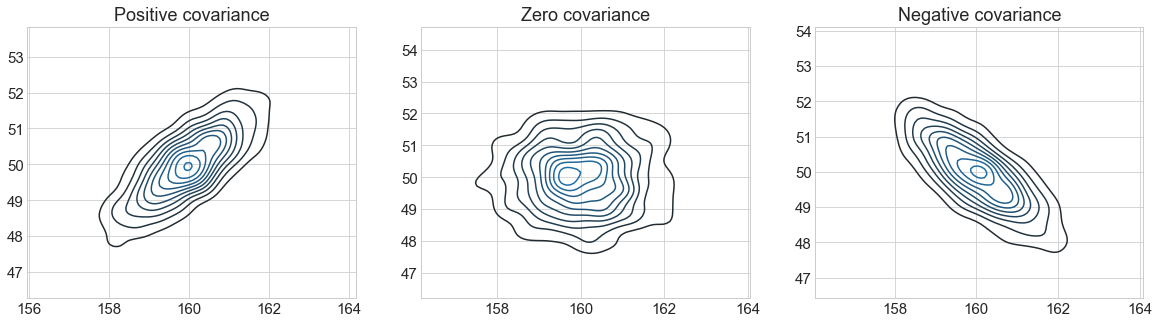

In [7]:
fig, ax = plt.subplots(1,3,figsize=(20,5))


### Positive covariance
mean = [160, 50]
cov  = [[1,.8],[.8,1]]  
x, y = np.random.multivariate_normal(mean, cov, 1000).T

sns.kdeplot(x,y,ax=ax[0])
ax[0].set_title('Positive covariance')


### Zero covariance
mean = [160, 50]
cov  = [[1,0],[0,1]]  
x, y = np.random.multivariate_normal(mean, cov, 1000).T

sns.kdeplot(x,y,ax=ax[1])
ax[1].set_title('Zero covariance')


### Negative covariance
mean = [160, 50]
cov  = [[1,-.8],[-.8,1]]  
x, y = np.random.multivariate_normal(mean, cov, 1000).T

sns.kdeplot(x,y,ax=ax[2])
ax[2].set_title('Negative covariance')

plt.show()

This fits nicely on a 2D plot, so we can visualise individual samples from our model very easily (the red x):

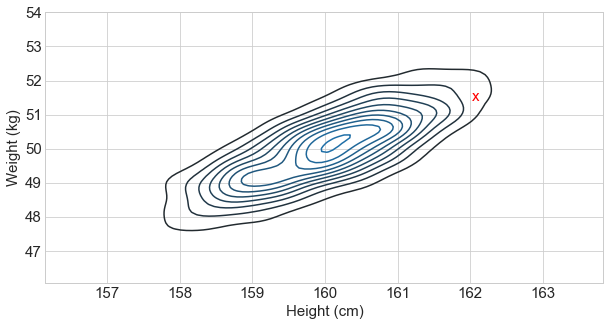

In [8]:
fig, ax = plt.subplots(figsize=(10,5))

### Positive covariance
mean = [160, 50]
cov  = [[1,.8],[.8,1]]  
x, y = np.random.multivariate_normal(mean, cov, 1000).T

s_x, s_y = np.random.multivariate_normal(mean, cov, 1).T

sns.kdeplot(x,y,ax=ax)

ax.annotate('x',(s_x,s_y),color='red')
ax.set_xlabel('Height (cm)')
ax.set_ylabel('Weight (kg)')

plt.show()

One of the mathematical niceties that we get from modelling everything as a Gaussian is that we can take slices from the 3D Gaussian above, and get 2D Gaussians as outputs. 

For example, imagine we are given as input a height of 159cm and we would like to output what we think a likely weight might be. We can "condition" our multivariate Gaussian on a height of 159cm by taking a slice through the 3D shape at the 159cm mark. 


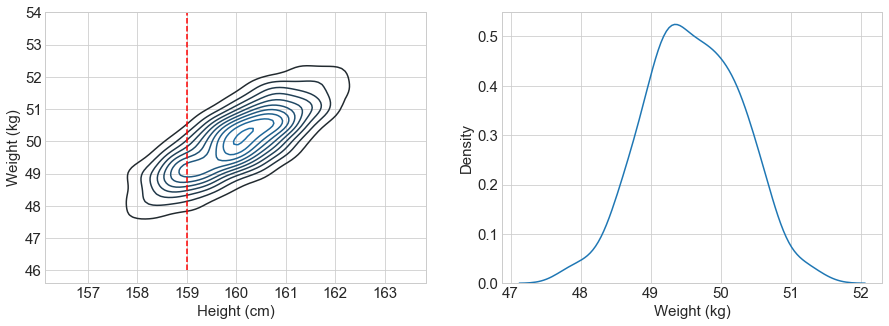

In [10]:
input_height = 159

fig, ax = plt.subplots(1,2, figsize=(15,5))

sns.kdeplot(x,y,ax=ax[0])
ax[0].plot([input_height]*10, np.linspace(46,54,10), linestyle='--', color='red')

ax[0].set_xlabel('Height (cm)')
ax[0].set_ylabel('Weight (kg)')

sns.kdeplot(y[x.astype(int) == 159],ax=ax[1]) ## conditioning the Gaussian on height=159
ax[1].set_xlabel('Weight (kg)')
ax[1].set_ylabel('Density')
plt.show()

Unfortunately, this kind of visualisation becomes completely impossible once we have more than three variables (dimensions) to consider. 

A more scalable way to picture taking samples from the distribution is to put each of the variables as individual locations on the x-axis, and to normalise the y-axis to the range 0-1:

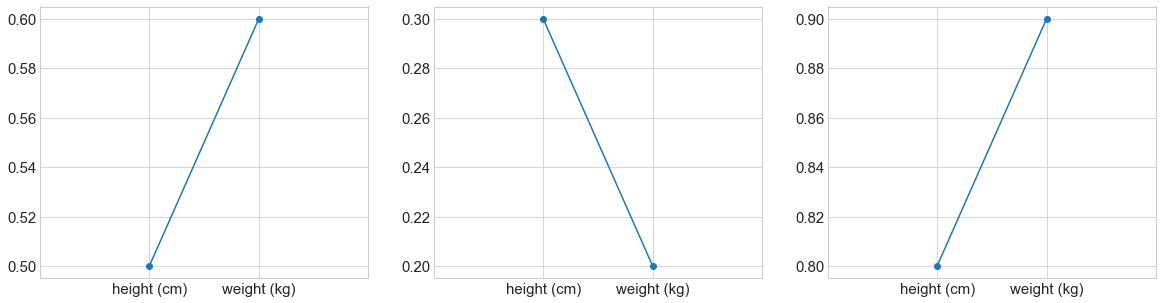

In [61]:
fig, axs = plt.subplots(1,3,figsize=(20,5))
axs = axs.ravel()


x = [0,1]
ys = [[0.5,0.6],[0.3,0.2],[0.8,0.9]]

for ax,y in zip(axs,ys):
    ax.plot(x,y, marker='o')
    ax.set_xticks([0,1])
    ax.set_xticklabels(['height (cm)', 'weight (kg)'])
    ax.set_xlim(-1,2)

plt.show()


To see how these samples correspond to samples on the plot above, let's do away with our height/weight example for a moment and imagine that we have two variables ($x_1, x_2$) each in the range 0-1.

To model them, we construct a multivariate Gaussian:

$$ \begin{bmatrix} x_1 \\ x_2 \\ \end{bmatrix} \sim \mathcal{N}\bigg(\mathbf{\mu} = \begin{bmatrix}0.3 \\ 0.6 \\ \end{bmatrix}, \mathbf{\Sigma} = \begin{bmatrix}1&0.9 \\ 0.9 & 1 \\\end{bmatrix}\bigg)$$ 

Now we can take a sample, and picture the sample in two ways:

Sample: 
	 x1:  [-1.366888]
	 x2:  [-1.36710588]


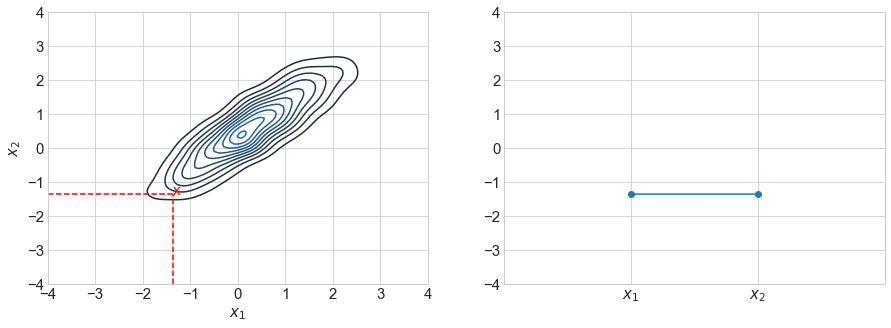

In [23]:

fig, ax = plt.subplots(1,2,figsize=(15,5))

### Positive covariance
mean = [0.3,0.6]
cov  = [[1,.9],[.9,1]]  

# set up a Gaussian
x, y = np.random.multivariate_normal(mean, cov, 1000).T
s_x, s_y = np.random.multivariate_normal(mean, cov, 1).T # take a sample

print('Sample: ')
print('\t x1: ',s_x)
print('\t x2: ',s_y)



##### plotting code
## first way to visualise
sns.kdeplot(x,y,ax=ax[0])

ax[0].plot([s_x]*10, np.linspace(-4,s_y,10), linestyle='--',color='red')
ax[0].plot(np.linspace(-4,s_x,10), [s_y]*10, linestyle='--',color='red')
ax[0].annotate('x',(s_x,s_y),color='red')
ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('$x_2$')
ax[0].set_xlim(-4,4)
ax[0].set_ylim(-4,4)

## second way to visualise
ax[1].plot([0,1],[s_x,s_y],marker='o')
ax[1].set_xticks([0,1])
ax[1].set_xticklabels(['$x_1$','$x_2$'])
ax[1].set_xlim(-1,2)
ax[1].set_ylim(-4,4)

plt.show()


I encourage you to re-run the above cell a few times to get some different samples so that you have a good intuition for how both visualisations work. It's also worth changing the means and covariance matrix and trying to predict what the outputs will look like. 

Something you might notice is that if you decrease the magnitude of the covariance, then the distance between $x_1$ and $x_2$ tends to be larger. This is roughly in line with what we would expect since the covariance describes exactly this. 

In order to do _conditioning_ in our new visualisation system (where we fix one variable at a certain value), all we have to do is fix one of the points at its current location, and continue sampling the others. 

### Generalising to more variables

Imagine now that we add a third variable into the mix: $x_3$. In our population model, this could be something like shoe size.

When designing our new covariance matrix, we decide that $x_3$ is quite related to $x2$, and a little less related to $x1$:

$$ \begin{bmatrix} x_1 \\ x_2 \\ x_3 \\ \end{bmatrix} \sim \mathcal{N}\Bigg(\mathbf{\mu} = \begin{bmatrix}0.3 \\ 0.6 \\ 0.4 \\ \end{bmatrix}, \mathbf{\Sigma} = \begin{bmatrix}1&0.9&0.8 \\ 0.9 & 1 & 0.9 \\ 0.8 & 0.9 & 1 \\  \end{bmatrix}\Bigg)$$ 


With three variables, this is a little tricky to visualise sampling the old way, but very natural in our new way:


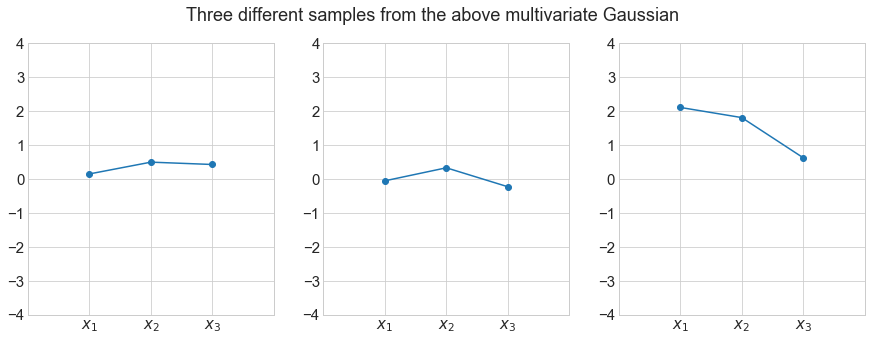

In [24]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

mean = [0.3,0.6,0.4]

cov  = [[1., .9, .8],
        [.9, 1., .9],
        [.8, .9, 1.]]

for ax in axs.ravel():
    x1,x2,x3 = np.random.multivariate_normal(mean, cov, 1).T
    ax.plot([1,2,3],[x1,x2,x3], marker='o')
    ax.set_xlim(0,4)
    ax.set_ylim(-4,4)
    ax.set_xticks([1,2,3])
    ax.set_xticklabels(['$x_1$','$x_2$','$x_3$'])

    
fig.suptitle('Three different samples from the above multivariate Gaussian')
plt.show()

We can likewise extend this to 4 variables:

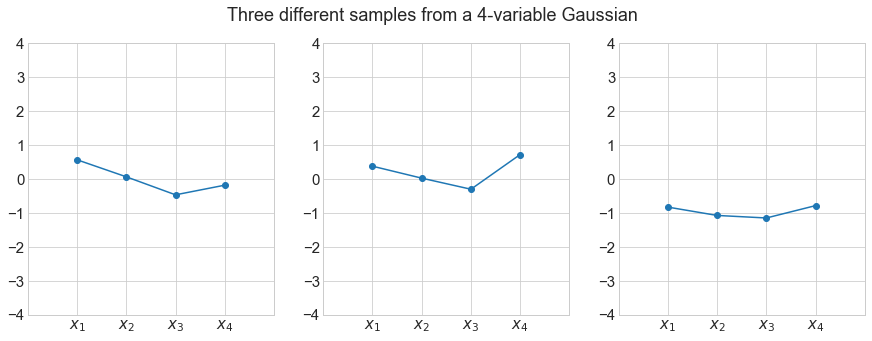

In [29]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

mean = [0.3,0.6,0.4,0.5]

cov  = [[1., .9, .8, .7],
        [.9, 1., .9, .8],
        [.8, .9, 1., .9],
        [.7, .8, .9, 1.]]

for ax in axs.ravel():
    x1,x2,x3,x4 = np.random.multivariate_normal(mean, cov, 1).T
    ax.plot([1,2,3,4],[x1,x2,x3,x4], marker='o')
    ax.set_xlim(0,5)
    ax.set_ylim(-4,4)
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(['$x_1$','$x_2$','$x_3$','$x_4$'])

    
fig.suptitle('Three different samples from a 4-variable Gaussian')
plt.show()

Or even more:

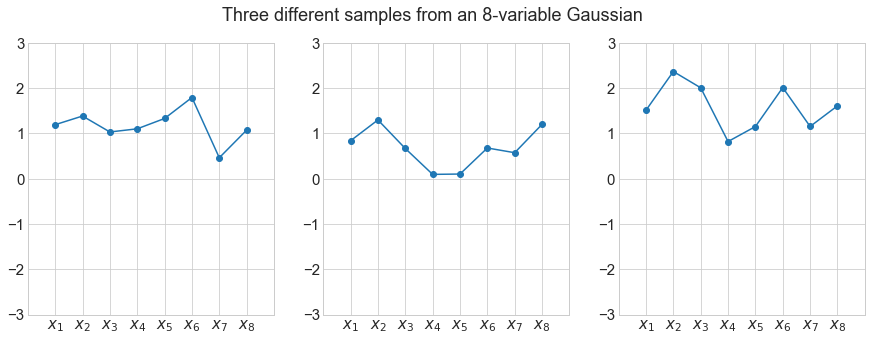

In [42]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

mean = [0.3,0.6,0.4,0.5,0.7,0.9,0.1,0.5]

cov  = [[1., .9, .8, .7, .6, .5, .4, .3],
        [.9, 1., .9, .8, .7, .6, .5, .4],
        [.8, .9, 1., .9, .8, .7, .6, .5],
        [.7, .8, .9, 1., .9, .8, .7, .6],
        [.6, .7, .8, .9, 1., .9, .8, .7],
        [.5, .6, .7, .8, .9, 1., .9, .8],
        [.4, .5, .6, .7, .8, .9, 1., .9],
        [.3, .4, .5, .6, .7, .8, .9, 1.]]

for ax in axs.ravel():
    xs = np.random.multivariate_normal(mean, cov, 1).T
    ax.plot(list(range(len(xs))),xs, marker='o')
    
    ax.set_xlim(-1,8)
    ax.set_ylim(-3,3)
    ax.set_xticks(list(range(len(xs))))
    ax.set_xticklabels(['$x_1$','$x_2$','$x_3$','$x_4$','$x_5$','$x_6$','$x_7$','$x_8$'])

    
fig.suptitle('Three different samples from an 8-variable Gaussian')
plt.show()

Now imagine that we want to condition the samples on a set of given values for the first four dimensions: